In [3]:
!pip install transformers timm --quiet

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import numpy as np
import os

data_dir = '/content/drive/MyDrive/Proyectos/radio'
train_path = os.path.join(data_dir, 'train')
val_path = os.path.join(data_dir, 'val')
test_path = os.path.join(data_dir, 'test')

BATCH_SIZE = 16
EPOCHS = 10
LR = 2e-5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_CLASSES = 2 # tuber / normal

# ==== Preprocesamiento ViT ====
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# ==== DataLoaders ====
train_ds = datasets.ImageFolder(train_path, transform=transform)
val_ds = datasets.ImageFolder(val_path, transform=transform)
test_ds = datasets.ImageFolder(test_path, transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# ==== Modelo Vision Transformer ====
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=N_CLASSES,
    ignore_mismatched_sizes=True
).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

# ==== Entrenamiento ====
def train_epoch(loader):
    model.train()
    running_loss = 0.0
    for imgs, labels in loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs).logits
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(loader.dataset)

def evaluate(loader):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs).logits
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)
            all_probs.extend(probs)
    acc = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)
    return acc, auc, cm

for epoch in range(EPOCHS):
    loss = train_epoch(train_loader)
    val_acc, val_auc, val_cm = evaluate(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f} | Val AUC: {val_auc:.4f}")

# ==== Evaluación en test ====
test_acc, test_auc, test_cm = evaluate(test_loader)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print("Test Confusion Matrix:\n", test_cm)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 | Loss: 0.0930 | Val Acc: 0.9956 | Val AUC: 0.9994
Epoch 2/10 | Loss: 0.0065 | Val Acc: 0.9978 | Val AUC: 0.9999
Epoch 3/10 | Loss: 0.0002 | Val Acc: 0.9967 | Val AUC: 0.9999
Epoch 4/10 | Loss: 0.0001 | Val Acc: 0.9978 | Val AUC: 0.9999
Epoch 5/10 | Loss: 0.0001 | Val Acc: 0.9978 | Val AUC: 0.9999
Epoch 6/10 | Loss: 0.0000 | Val Acc: 0.9978 | Val AUC: 0.9999
Epoch 7/10 | Loss: 0.0000 | Val Acc: 0.9978 | Val AUC: 0.9999
Epoch 8/10 | Loss: 0.0000 | Val Acc: 0.9978 | Val AUC: 0.9999
Epoch 9/10 | Loss: 0.0000 | Val Acc: 0.9978 | Val AUC: 0.9999
Epoch 10/10 | Loss: 0.0000 | Val Acc: 0.9978 | Val AUC: 0.9999

Test Accuracy: 0.9855
Test AUC: 0.9999
Test Confusion Matrix:
 [[605   1]
 [ 16 549]]


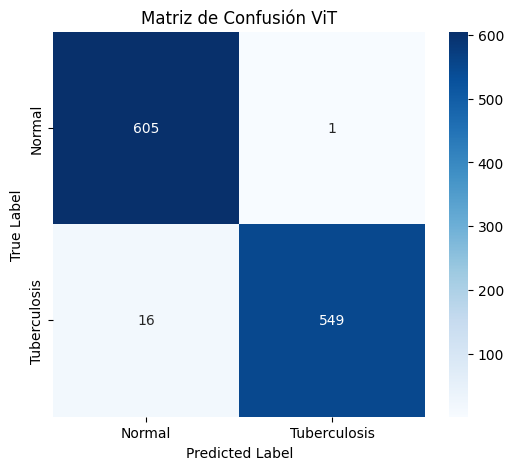

              precision    recall  f1-score   support

      Normal       0.97      1.00      0.99       606
Tuberculosis       1.00      0.97      0.98       565

    accuracy                           0.99      1171
   macro avg       0.99      0.99      0.99      1171
weighted avg       0.99      0.99      0.99      1171



In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# 1. Obtenemos las predicciones del modelo ViT sobre el test set (probabilidades y clases)
vit_probs = []
vit_preds = []
vit_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs).logits
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Probabilidad de "Tuberculosis"
        preds = outputs.argmax(dim=1).cpu().numpy()
        vit_probs.extend(probs)
        vit_preds.extend(preds)
        vit_labels.extend(labels.cpu().numpy())

vit_probs = np.array(vit_probs)
vit_preds = np.array(vit_preds)
vit_labels = np.array(vit_labels)

# 2. Matriz de confusión y heatmap (como en tu ejemplo CNN)
cm = confusion_matrix(vit_labels, vit_preds)
labels_names = ['Normal', 'Tuberculosis']
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Matriz de Confusión ViT")
plt.show()

# 3. Reporte de clasificación
print(classification_report(vit_labels, vit_preds, target_names=labels_names))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Matriz de Confusión ViT")
plt.savefig('/content/drive/MyDrive/Proyectos/radio/confusion_matrix_vit.png', dpi=300)
plt.close()
